In [1]:
#====================================================================================================
# kogpt2 를 이용해 훈련한 Q&A 훈련 예시
#
# => train loss, val loss 만 구함
#
# => 여기서는 훈련할때 <question>, <answer> 2개의 구분자 토큰을 지정하였음. 
# [훈련 dataset]
# => input_ids = '지문<qeustion>질문<answer>답변</s>'   
# => labels = input_ids와 동일
#
# [Q&A 훈련 과정]
# 
# 1. gpt-2 모델 선언(GPT2LMHeadModel), tokenizer 선언(PreTrainedTokenizerFast)
# 2. '지문 + <qeustion> + 질문+ <answer>+ 답변+ </s>'   ' 식으로 된 훈련 dataset 생성
# 3. 모델에 input_ids, lables 을 입력하여 훈련 시킴
#====================================================================================================

import torch
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler 
import numpy as np
import pandas as pd
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

from tqdm.notebook import tqdm
import os
import time
from myutils import GPU_info, seed_everything, mlogging, SaveBERTModel, AccuracyForMLM
from summarizer import TransformerSummarizer
model_path='../model/gpt-2/kogpt-2-ft-summarizer-0509/'
#model_path='../model/gpt-2/kogpt-2/'
#model_path='skt/kogpt2-base-v2'
#model_path = "gpt2-medium"

# 출력
OUTPATH = '../model/gpt-2/kogpt-2-ft-summarizer-QA-0510/'

device = GPU_info()
print(device)

#seed 설정
seed_everything(222)

#logging 설정
logger =  mlogging(loggername="gpt2-ft", logfilename="../log/gpt2-ft")

logfilepath:../log/bwdataset_2022-05-10.log
logfilepath:../log/qnadataset_2022-05-10.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:../log/gpt2-ft_2022-05-10.log


In [2]:
# Q&A 파일 열기
corpus_fpath = "../korpora/korQuAD/KorQuAD_v1.0_train.csv"
# csv 파일 로딩해봄
df = pd.read_csv(corpus_fpath)

# df1을 list로 변환
context_list = np.array(df['context'].tolist())
question_list = np.array(df['question'].tolist())
answer_list = np.array(df['answer'].tolist())

# 지문<qeustion>질문<answer>답변 식으로 훈련 문장 만듬
data_list = []
for context, question, answer in zip(context_list, question_list, answer_list):
    data = context + "<question>" + question + "<answer>" + answer 
    data_list.append(data)

In [3]:
data_list[0]

'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.<question>바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?<answer>교향곡'

In [5]:
# 총 데이터 계수
print(len(data_list))

57688


In [6]:
# 훈련 데이터의 평균 단어 길이를 구함
data_len_list = [len(data.split()) for data in data_list]
print(f'max_len:{max(data_len_list)}')

# 평균 단어의 길이를 얻어옴
avg_length = sum(data_len_list)/len(data_len_list)
print(f'avg_len:{avg_length}')

max_len:2249
avg_len:122.96723755373735


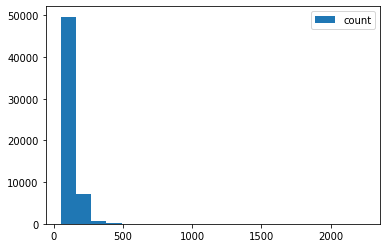

In [7]:
import matplotlib.pyplot as plt
plt.hist(data_len_list, bins=20, label='count')
plt.legend()
plt.show()

In [8]:
# 평균 단어의 길이보다 2배정도 설정
max_length = 256

In [9]:
# tokenizer 로딩 
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_path,
                                                   bos_token='</s>',
                                                   eos_token='</s>',
                                                   unk_token='<unk>',
                                                   pad_token='<pad>',
                                                   mask_token='<mask>')

In [10]:
# 모델 정의 하고, embedding size를 tokenizer 사이즈만큼 조정
model = GPT2LMHeadModel.from_pretrained(model_path)

model.resize_token_embeddings(len(tokenizer))
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [11]:
# ** 구분자  <question><answer> 토큰의 길이를 얻어옴
print(tokenizer.encode("<question>"))
print(tokenizer.encode("<answer>"))
extra_length = len(tokenizer.encode("<question>")) + len(tokenizer.encode("<answer>"))
print(f'***<question><answer> token len:{extra_length}')


[9724, 14104, 9792, 10651, 405]
[9724, 24742, 461, 9485, 405]
***<question><answer> token len:10


In [12]:
# dataset 설정 함수
class myDataset(Dataset):
    def __init__(self, tokenizer, sentences, max_len, my_token_len):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.eos = self.tokenizer.eos_token
        self.eos_id = self.tokenizer.eos_token_id
        self.sentences = sentences
        self.my_token_len = my_token_len
        self.result = []
        
        for sentence in tqdm(self.sentences):
            # 한 문장 뒤에 </s>(EOS 토큰) 추가
            tokenized = self.tokenizer.encode(sentence + self.eos)
            #print(tokenized)
            # padd 
            padded = self.pad_truncate(tokenized)
            
            # 출력
            self.result.append(torch.tensor(padded))
           
    def __len__(self):
        return len(self.result)
    
    def __getitem__(self, item):
        return self.result[item]
    
    # padd 붙이는 함수
    def pad_truncate(self, name):
        
        # name_length는 총 name 길이에서 - my_token 길이를 뺀 길이가 됨
        # (예: name 길이 = 110 이면 name_length = 110 - 8 = 102)
        name_length = len(name) - self.my_token_len
        
        # name 길이 < 100 작으면, 뒤에 108개까지는 eos_id(1)로 padd 붙임
        if name_length < self.max_len:
            difference = self.max_len - name_length
            result = name + [self.eos_id] * difference
        # name 길이 > 100 크면, 100+7 까지만 name 값 출력하고, 뒤에 eos_id(1) 붙임 = 총 108개가 됨
        elif name_length > self.max_len:
            result = name[:self.max_len + self.my_token_len - 1]+[self.eos_id]
        else:
            result = name
        
        return result
        

In [ ]:
# dataset 만듬
dataset = myDataset(tokenizer, data_list, max_length, extra_length)

In [ ]:
dataset[1]

In [ ]:
# 데이터 로더 생성 
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# 훈련 시작 

##################################################
epochs = 2            # epochs
learning_rate = 3e-5  # 학습률
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = total_steps * 0.1 #10% of train data for warm-up

# 손실률 보여줄 step 수
p_itr = int(len(train_loader)*0.1)  
    
# step마다 모델 저장
save_steps = int(total_steps * 0.5)
    
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1

total_loss = 0
list_train_loss = []

# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
model.zero_grad(set_to_none=True)
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
        model.zero_grad(set_to_none=True)# 그래디언트 초기화(*set_to_none=True 로 설정하면, 그래디언트 업데이트시, 쓰기작업만 수행되어 속도가 빨라진다)
        
        # 입력 값 설정
        input_ids = data.to(device)
        labels = data.to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        labels=labels)
        
       
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # logits_shape: torch.Size([32, 68, 51200])
        # => batch_size, sequence_max_len, token_len
        #print(f'logits_shape: {logits.shape}')                    
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # ***further pretrain 에는 손실률 계산을 넣지 않음
        # 정확도 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            
            # 손실률 계산
            total_loss += loss.item()
                
            #===========================================
            # 정확도(Accurarcy) 계산
            #correct = AccuracyForMLM(logits, labels, attention_mask)           
            #total_correct += correct.sum().item() 
            #total_len += attention_mask.sum().item()
            #=========================================
     
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                
                train_loss = total_loss/p_itr
                                   
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}'.format(epoch+1, epochs, itr, train_loss))
                     
                list_train_loss.append(train_loss)
                 
                # 변수들 초기화    
                total_loss = 0
                ####################################################################
            if itr % save_steps == 0:
                #전체모델 저장
                SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

        itr+=1

In [ ]:
# 모델 저장
SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

In [ ]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
#plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()


In [ ]:
# 추론시 topk 알고리즘 사용
def topk(probs, n=9):
    probs = torch.softmax(probs, dim=-1)
    
    tokensProb, topIx = torch.topk(probs, k=n)
    tokensProb = tokensProb / torch.sum(tokensProb)
    
    tokensProb = tokensProb.cpu().detach().numpy()
    
    choice = np.random.choice(n,1,p=tokensProb)
    tokenId = topIx[choice][0]
    
    return int(tokenId)

In [ ]:
# summarize 추론 처리 함수 
def model_infer(model, tokenizer, review, max_length=15):
    review_encoded = tokenizer.encode(review)
    result = review_encoded
    initial_input = torch.tensor(review_encoded).unsqueeze(0).to(device)
    
    with torch.set_grad_enabled(False):
        outputs = model(initial_input)
        
        logits = outputs.logits[0,-1]
        print(logits.shape)  # embedding 계수 출력됨
        #result.append(topk(logits))
        #print(result)
        
        for _ in range(max_length):
            input = torch.tensor(result).unsqueeze(0).to(device)
            outputs = model(input)
            logits = outputs.logits[0,-1]
            res_id = topk(logits)
            
            if res_id == tokenizer.eos_token_id:
                return tokenizer.decode(result)
            else:
                result.append(res_id)
                
    return tokenizer.decode(result)
            

In [ ]:
# A review is initially fed to the model.
# A choice from the top-k choices is selected.
# The choice is added to the summary and the current sequence is fed to the model.
# Repeat steps 2 and 3 until either max_len is achieved or the EOS token is generated.

context = '''
전남도는 청정하고 안전한 신재생에너지 보급 확산을 위해 추진하는 ‘2022년 신재생에너지 보급 주택지원사업’ 참여 가구를 9일부터 6월 3일까지 모집한다고 밝혔다.
신재생에너지 보급 주택지원사업은 주택에 태양광, 태양열, 연료전지, 지열 등 신재생에너지 설비를 설치하는 도민에게 정부 지원금 외에 도비와 시군비를 추가로 지원하는 사업이다.
사업 대상자로 선정되면 설치비 자부담분(50%)의 40%를 도비와 시군비로 지원하기 때문에 비용부담을 줄일 수 있다.
전남도는 올해 지방비 17억원을 들여 1600여 가구에 신재생에너지 설비를 보급할 계획이다.
지원을 바라는 주택 소유자는 한국에너지공단 그린홈 누리집에서 회원가입 후 공단에 등록한 참여업체를 지정해 신청하면 된다.
지방비 보조금은 한국에너지공단의 최종 사업 승인 후 해당 시군에 지원 신청을 하면 예산 범위에서 선착순 지원한다.
자세한 사항은 한국에너지공단 광주전남지역본부, 전남도 에너지신산업과, 시군 에너지업무 담당 부서로 문의하면 된다.
주택에 3KW 태양광 설비를 설치하면 총 설치비 516만원 중 국비 258만원과 추가로 지방비 103만원을 지원하기 때문에 155만원만 자부담하면 된다.
3KW 태양광 설비를 설치한 가구는 월 4만5000원씩 연간 54만원의 전기요금을 절감할 수 있다.
'''

question = '전기요금 절감 금액은?'

inputs = context + "<question>" + question + "<answer>"

output = model_infer(model, tokenizer, inputs , 100)
#print(output)

answer = output.split("<answer>")[1].strip()
print(answer)